In [1]:
# univariate multi-step lstm
# %pip install chart_studio --user
from math import sqrt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
import matplotlib as mpl
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio

# for changing the plot size in the Jupyter Notebook output
%matplotlib inline
# sets the plot size to 12x8
mpl.rcParams['figure.figsize'] = (12,8)

In [17]:
# qd = pd.read_csv(r'FRED_QD_20191113.csv', header=0, skiprows=[1,2])
md = pd.read_csv(r'FRED_MD_20191113.csv', header=0, skiprows=[1,2])
data = md
# data['CPI'] = ((data['CPIAUCSL'].shift(-12) / data['CPIAUCSL']) - 1)*100
# data = md.merge(qd, how='left', on='sasdate')
# data['GDP_pad'] = data.GDPC1.fillna(method='pad')
# data['GDP_pad_shift'] = data['GDP_pad'].shift(-3)
# data['GDP_change'] = (data['GDP_pad_shift'] - data['GDP_pad'])/3
# data['GDP'] = data['GDP_change'].cumsum() + data['GDPC1'][1]
data['sasdate'] = pd.to_datetime(data['sasdate'], format="%m/%d/%Y")
data.set_index('sasdate', inplace=True)
# data = data.loc[:, ~data.columns.str.contains('_y')]
# data = data.drop(['GDP_pad', 'GDP_pad_shift', 'GDP_change'], axis=1)
data = data.fillna(method='pad').fillna(0).iloc[1:,:]
data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DARfor_Step1,DARfor_Step2,DARfor_Step3,DARfor_Step4,DARfor_Step5,DARMfor_Step1,DARMfor_Step2,DARMfor_Step3,DARMfor_Step4,DARMfor_Step5
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-03-01,2462.689,2314.0,17.647,2.934254e+05,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1959-04-01,2478.744,2330.3,17.584,2.993317e+05,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1959-05-01,2493.228,2345.8,17.796,3.013730e+05,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1959-06-01,2500.989,2352.9,17.861,3.013648e+05,18849.75209,24.2866,24.6382,23.2066,33.1606,23.3156,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1959-07-01,2499.525,2351.0,17.801,3.050348e+05,18843.52934,23.7050,24.6670,23.3988,33.5964,23.7773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,16979.701,14096.2,120.433,1.503347e+06,518131.00000,109.2508,104.3141,103.0011,105.0774,120.4686,...,3.036702,2.923689,2.905251,2.738333,2.423327,2.680101,3.069954,2.978124,2.969964,2.659986
2019-06-01,17032.129,14138.7,120.683,1.515264e+06,520055.00000,109.3078,104.6945,103.5907,105.6160,122.1042,...,2.551368,3.007423,2.915597,2.886860,2.733533,2.641499,2.775589,3.007836,2.962984,3.038477
2019-07-01,17009.545,14113.3,121.004,1.514859e+06,523922.00000,109.1045,104.5174,103.4120,105.6055,122.6444,...,2.551368,3.007423,2.915597,2.886860,2.733533,2.641499,2.775589,3.007836,2.962984,3.038477


In [18]:
def split_dataset_1(data, train_share, idx=None):
    '''split a univariate dataset into train/test sets'''
    if idx is not None:
        index = idx
    else: 
        index = round(len(data)*train_share)
    if isinstance(data, pd.DataFrame):
        data = data.values
    train, test = data[:index], data[index:]
    return train, test
    # restructure into windows of yearly data

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# split a multivariate sequence into samples
def split_sequences_multi(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix]
        X.append(seq_x)
    return np.array(X)


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
    
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
    
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    yhat_list = []
    j = 0
    for y in yhat:
        yhat_list.append(y + history[-(interval-j)])
        j += 1
    return yhat_list
 
    
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value, n_out):
#     print(X)
#     print(value)
    new_row = [x for x in X] + [y for y in value[0]]
#     print(new_row)
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -n_out:]


def moving(x, window):
    ret = np.cumsum(x, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window


def moving_frame(x, window_list=[3]):
    frame = pd.DataFrame()
    for i in window_list:
        frame['{}'.format(i)] = np.pad(moving(x, i), (i-1,0),'constant', constant_values=(0))
    return frame.values
        

def model_branch(input_shape, filter_size, dense_neuron=100, nb_filters=10, drop=.3, batch_size=1):
    #the input is a time series of length n and width 19
    input_seq = Input(batch_shape=(batch_size, input_shape[1], input_shape[2]))
    #1-D convolution and global max-pooling
    conv = Conv1D(nb_filters, filter_size, padding="same", activation="relu")(input_seq)
#     pool = GlobalMaxPooling1D()(conv)
    #dense layer with dropout regularization
#     flat = Flatten()(pool)
#     compressed = Dense(dense_neuron, activation="relu")(flat)
#     compressed = Dropout(drop)(compressed)
    model = Model(inputs=input_seq, outputs=conv)
    return model


def model_cnn(merged_shape, nb_filters=10, filter_size=8):
    input_seq = Input(shape=(merged_shape))
    conv1 = Conv1D(nb_filters, filter_size, padding="same", activation="relu")(input_seq)
    pool1 = GlobalMaxPooling1D()(conv1)
    model = Model(inputs=input_seq, outputs=pool1)
    return model


# fit an CONV network to training data
def fit_convlstm(train, validate=False, batch_size=1, nb_epoch=1000, neurons=(100,100,100), filter_size=8, 
                 drop=.5, loss='mean_absolute_error', verbose=0, iteration=0, optimizer='sgd', 
                 callback=False, window=24, stepsout=12, l_rate=.0001, decay=0, patience=100, 
                 average_window=[3, 6, 12]):

    if validate:
        orig, y_train= split_sequence(train, window, stepsout)
        moving_average = split_sequences_multi(moving_frame(train, average_window), window, stepsout)[:-1]
        orig_val = orig[::10]
        orig_val = orig_val.reshape(orig_val.shape[0], orig_val.shape[1], 1)
        moving_average_val = moving_average[::10]
        moving_average_val = moving_average_val.reshape(moving_average_val.shape[0], moving_average_val.shape[1], 
                                                        moving_average_val.shape[2])
        orig = orig[np.mod(np.arange(orig.shape[0]),10)!=0]
        orig = orig.reshape(orig.shape[0], orig.shape[1], 1)
        moving_average = moving_average[np.mod(np.arange(moving_average.shape[0]),10)!=0]
        moving_average = moving_average.reshape(moving_average.shape[0], moving_average.shape[1], 
                                                moving_average.shape[2])
        y_val = y_train[::10]
        n_output_val = y_val.shape[1] * y_val.shape[2]
        y_val = y_val.reshape((y_val.shape[0], n_output_val))
        y_train = y_train[np.mod(np.arange(y_train.shape[0]),10)!=0]
        val = ([orig_val, moving_average_val], y_val)
    else:
        val=None
        orig, y_train= split_sequence(train, window, stepsout)
        moving_average = split_sequences_multi(moving_frame(train, average_window), window, stepsout)
        moving_average = moving_average.reshape(moving_average.shape[0], moving_average.shape[1], 
                                                moving_average.shape[2])
    
    if iteration == 0:
        keras.backend.clear_session() 
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=l_rate, beta_1=0.9, beta_2=0.999, amsgrad=True)
    if optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=l_rate, momentum=0.9, nesterov=True)
    if callback:
        earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    else:
        earlystop = None
    
    if iteration == 0:
        n_output = y_train.shape[1] * y_train.shape[2]
        y_train = y_train.reshape((y_train.shape[0], n_output))

        input_raw = Input(batch_shape=(batch_size, orig.shape[1],orig.shape[2]))
        input_smooth = Input(batch_shape=(batch_size, moving_average.shape[1], moving_average.shape[2]))

        raw_branch = model_branch(orig.shape, filter_size, dense_neuron=neurons[0], batch_size=batch_size)
        smooth_branch = model_branch(moving_average.shape, filter_size, dense_neuron=neurons[0], 
                                     batch_size=batch_size)

        raw_embedding = raw_branch(input_raw)
        smooth_embedding = smooth_branch(input_smooth)

        merged = concatenate([raw_embedding, smooth_embedding])
    #     cnn_model = model_cnn(merged.get_shape()[1])
    #     cnn_model = TimeDistributed(cnn_model)
    #     cnn = cnn_model(merged)
    #     cnn = cnn_model(merged)
    #     shp1 = Reshape((1,cnn.shape[1]))(cnn)
        skip00 = concatenate([input_raw, input_smooth, merged])
        skip00 = concatenate([skip00, merged])
        dropout00 = Dropout(drop)(skip00)
        lstm1 = LSTM(neurons[1], return_sequences=True, stateful=True)(dropout00)
        lstm2 = LSTM(neurons[1], return_sequences=True, stateful=True)(lstm1)
        skip0 = concatenate([lstm2, merged])
        dropout0 = Dropout(drop)(skip0)
        dense1 = Dense(neurons[2], activation='relu')(dropout0)
        dense2 = Dense(neurons[2], activation='relu')(dense1)
        dense3 = Dense(neurons[2], activation='relu')(dense2)
        skip1 = concatenate([dense3, lstm2])
        dropout1 = Dropout(drop)(skip1)
        dense4 = Dense(neurons[2]*.75, activation='relu')(dropout1)
        dense5 = Dense(neurons[2]*.75, activation='relu')(dense4)
        dense6 = Dense(neurons[2]*.75, activation='relu')(dense5) 
        skip2 = concatenate([dense6, skip1])
        dropout2 = Dropout(drop)(skip2)
        dense7 = Dense(neurons[2]*.75*.75, activation='relu')(dropout2)
        dense8 = Dense(neurons[2]*.75*.75, activation='relu')(dense7)
        dense9 = Dense(neurons[2]*.75*.75, activation='relu')(dense8)    
        skip3 = concatenate([dense9, skip2])
        dropout = Dropout(drop)(skip3)
        output = Dense(n_output)(dropout)
        model = Model(inputs=[input_raw, input_smooth], outputs=output)
        model.compile(loss=loss, optimizer=opt)

        model.summary()
        
    if validate:
        model_loss = model.fit([orig, moving_average], y_train, validation_data=val,
                               epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False,
                               callbacks=earlystop)
        return model, model_loss.history['loss'], model_loss.history['val_loss']
    else:
        model_loss = model.fit([orig, moving_average], y_train, validation_data=val,
                                epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False,
                                callbacks=earlystop)
        return model, model_loss.history['loss'], None



In [45]:
# transform data to be stationary
raw_values = data.GS10.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
# supervised = timeseries_to_supervised(diff_values, 1)
# print(supervised.shape)
# supervised_values = supervised.values
 
# split data into train and test-sets
train, test = split_dataset_1(diff_values, .7)
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train.values.reshape(-1, 1), test.values.reshape(-1, 1))

window=24
stepsout=12
# fit the model
time_start = datetime.now()
conv_model, loss, val_loss = fit_convlstm(train_scaled, validate=True, batch_size=1, nb_epoch=25000,
                                          neurons=(600,600,600), filter_size=4, drop=0.4, optimizer='sgd',
                                          window=window, callback=True, stepsout=stepsout, l_rate=.0001,
                                          patience=100)
time_fit = datetime.now() - time_start

# # forecast the entire training dataset to build up state for forecasting
# # train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)

# orig_test = test[:, 0].reshape(test.shape[0], 1, 1)
# moving_average_test = moving_frame(test[:, 0], [3, 6, 12])
# moving_average_test = moving_average_test.reshape(moving_average_test.shape[0], moving_average_test.shape[1], 1)
# predictions = conv_model.predict([orig_test, moving_average_test], batch_size=None)
loss += [np.nan] * (25000 - len(loss))
val_loss += [np.nan] * (25000 - len(val_loss))
loss_df = pd.DataFrame({'loss': loss})
val_loss_df = pd.DataFrame({'val_loss': val_loss})

start_idx = window + stepsout

# walk-forward validation on the test data
# walk-forward validation on the test data
predictions = list()
history = train.values[:start_idx]
for i in range(len(train[start_idx:])):
    scaler, train_scaled, test_scaled = scale(history.reshape(-1, 1), train[i+start_idx].reshape(1,-1))
    # make one-step forecast
    train_stack = np.vstack((train_scaled, test_scaled))
    split = split_sequence(train_stack, window, stepsout)
    X = split[0][-1]
    y = split[1][-1]
    orig_ = X.reshape(1, X.shape[0], X.shape[1])
    moving_average_ = split_sequences_multi(moving_frame(train_stack, [3, 6, 12]), window, stepsout)[-1]
    moving_average_ = moving_average_.reshape(1, moving_average_.shape[0], 
                                            moving_average_.shape[1])
    yhat = conv_model.predict([orig_, moving_average_], batch_size=1)
    yhat = yhat[-1]
#     print(yhat.shape)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat, stepsout)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, interval=len(train[start_idx:])+len(test)+1-i)
    # store forecast
    predictions.append(yhat)
    history = np.append(history, train[i+start_idx])
    
history = train.values
iteration = 0
for i in range(len(test)):
    scaler, train_scaled, test_scaled = scale(history.reshape(-1, 1), test.values[i].reshape(1, -1))
    # make one-step forecast
    train_stack = np.vstack((train_scaled, test_scaled))
    split = split_sequence(train_stack, window, stepsout)
    X = split[0][-1]
    y = split[1][-1]
    orig_ = X.reshape(1, X.shape[0], X.shape[1])
    moving_average_ = split_sequences_multi(moving_frame(train_stack, [3, 6, 12]), window, stepsout)[-1]
    moving_average_ = moving_average_.reshape(1, moving_average_.shape[0], 
                                            moving_average_.shape[1])
    yhat = conv_model.predict([orig_, moving_average_], batch_size=1)
    yhat = yhat[-1]
    # invert scaling
    yhat = invert_scale(scaler, X, yhat, stepsout)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, interval=len(test)+1-i)
    # store forecast
    predictions.append(yhat)
    history = np.append(history, test.values[i])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 24, 1)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(1, 24, 3)]         0                                            
__________________________________________________________________________________________________
model (Model)                   (1, 24, 10)          50          input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (1, 24, 10)          130         input_2[0][0]                    
____________________________________________________________________________________________

In [46]:
print('Time to train:', time_fit)
predictions_array = np.array(predictions)
# data_plt = pd.DataFrame(data.CPIAUCSL['2001-08-01':])
pred_df = pd.DataFrame({'T+1': predictions_array[:, 0], 'T+2': predictions_array[:, 1],
                         'T+3': predictions_array[:, 2], 'T+4': predictions_array[:, 3],
                         'T+5': predictions_array[:, 4], 'T+6': predictions_array[:, 5],
                         'T+7': predictions_array[:, 6], 'T+8': predictions_array[:, 7],
                         'T+9': predictions_array[:, 8], 'T+10': predictions_array[:, 9],
                         'T+11': predictions_array[:, 10], 'T+12': predictions_array[:, 11]})

pred_plt = pd.DataFrame({'T+1' : pred_df['T+1'], 'T+2' : pred_df['T+2'].shift(1),
                         'T+3' : pred_df['T+3'].shift(2), 'T+4' : pred_df['T+4'].shift(3),
                         'T+5' : pred_df['T+5'].shift(4), 'T+6' : pred_df['T+6'].shift(5),
                         'T+7' : pred_df['T+7'].shift(6), 'T+8' : pred_df['T+8'].shift(7),
                         'T+9' : pred_df['T+9'].shift(8), 'T+10' : pred_df['T+10'].shift(9),
                         'T+11': pred_df['T+11'].shift(10), 'T+12' : pred_df['T+12'].shift(11)})
# for col in list(pred_plt):
#     pred_plt['{}_cpi'.format(col)] = ((pred_plt[col].shift(-12) / pred_plt[col]) - 1)*100
# for col in list(pred_plt)[:-12]:
#     pred_plt['{}_cpi_diff'.format(col)] = pred_plt[col].shift(-1) - pred_plt[col]

pred_plt['raw_values'] = raw_values[start_idx:-1]
pred_plt['raw_'] = data.GS10.values[start_idx:-1]
pred_plt['SPF T+1'] = data.SPFfor_Step1.values[start_idx:-1]
pred_plt['SPF T+3'] = data.SPFfor_Step2.values[start_idx:-1]
pred_plt['SPF T+6'] = data.SPFfor_Step3.values[start_idx:-1]
pred_plt['SPF T+9'] = data.SPFfor_Step4.values[start_idx:-1]
pred_plt['SPF T+12'] = data.SPFfor_Step5.values[start_idx:-1]

pred_plt['DARM T+1'] = data.DARMfor_Step1.values[start_idx:-1]
pred_plt['DARM T+3'] = data.DARMfor_Step2.values[start_idx:-1]
pred_plt['DARM T+6'] = data.DARMfor_Step3.values[start_idx:-1]
pred_plt['DARM T+9'] = data.DARMfor_Step4.values[start_idx:-1]
pred_plt['DARM T+12'] = data.DARMfor_Step5.values[start_idx:-1]

cols = ['SPF T+1','SPF T+3','SPF T+6','SPF T+9','SPF T+12', 
        'DARM T+1','DARM T+3','DARM T+6','DARM T+9','DARM T+12']
pred_plt[cols] = pred_plt[cols].replace({0:np.nan})

# pred_plt['raw_cpi_diff'] = pred_plt['raw_values'].shift(-1) - pred_plt['raw_values']
pred_plt['date'] = data.index[start_idx:-1]
pred_plt.set_index('date', inplace=True)

mpl.rcParams['figure.figsize'] = (24,16)

results = pd.DataFrame({'Period':[], 'Overall MSE':[], 'Overall MAE':[], 'Test MSE':[], 'Test MAE':[]})

for col in list(pred_plt)[:-12]:
    ovr_mse = mean_squared_error(pred_plt['raw_'].values[11:-23], pred_plt[col].values[11:-23])
    ovr_mae = mean_absolute_error(pred_plt['raw_'].values[11:-23], pred_plt[col].values[11:-23])
    test_mse = mean_squared_error(pred_plt['raw_'].iloc[round((len(pred_plt)-20)*.7):-23], 
                                  pred_plt[col].iloc[round((len(pred_plt)-20)*.7):-23])
    test_mae = mean_absolute_error(pred_plt['raw_'].iloc[round((len(pred_plt)-20)*.7):-23], 
                                   pred_plt[col].iloc[round((len(pred_plt)-20)*.7):-23])
#     print(col,': Overall RMSE: %.3f' % sqrt(ovr_mse), 'Test RMSE: %.3f' % sqrt(test_mse))
#     print(col,': Overall MAE: %.3f' % ovr_mae, 'Test MAE: %.3f' % test_mae)
    row = pd.DataFrame({'Period':[col], 'Overall MSE':[ovr_mse], 'Overall MAE':[ovr_mae], 'Test MSE':[test_mse], 'Test MAE':[test_mae]})
    results = results.append(row)
    
# for col in list(pred_plt)[:-2]:
#     plt.plot(pred_plt[col][:-23], label=col)
# # line plot of observed vs predicted
# # plt.plot(raw_values[20:], color='blue')
# plt.plot(pred_plt['raw_'][:-23], color='green', label='RAW')
# # plt.plot(test[:,0], color='green')
# plt.legend(prop={'size': 20})
# plt.show()

# for col in list(pred_plt)[:-2]:
#     plt.plot(pred_plt[col].iloc[round((len(pred_plt)-20)*.7):-23], label=col)
# plt.plot(pred_plt['raw_'].iloc[round((len(pred_plt)-20)*.7):-23], color='green', label='RAW')
# # plt.plot(test[:,0], color='green')
# plt.legend(prop={'size': 20})
# plt.show()

# i = 0
# for col in list(pred_plt)[:-2]:
#     plt.plot(pred_plt[col].iloc[round((len(pred_plt)-20)*.7):-23], label=col)
#     plt.plot(pred_plt['raw_'].iloc[round((len(pred_plt)-20)*.7):-23], color='green', label='RAW')
#     plt.title(col)
#     plt.show()

colorlist = ['#27ACAA', '#A4E9B9', '#228941', 
             '#9EE9E8', '#1D817F', '#A97FF0',
             '#2E0C68', '#FFB3AF', '#9B0800',
             '#FF6D00', '#BF5200', '#0C4672',
             '#057ED8']

fig = go.Figure()

fig.update_layout(
    paper_bgcolor='#FFFFFF',
    plot_bgcolor='#FFFFFF'
)


fig.add_trace(
        go.Scatter(x=list(pred_plt.index),
                   y=list(pred_plt['raw_']),
                   name='10-year rate',
                   line=dict(color=colorlist[0])),)

# Add Traces
i = 0
for col in ['T+1','T+2','T+3','T+4','T+5','T+6','T+7','T+8','T+9','T+10','T+11','T+12']:
    i+=1
    fig.add_trace(
        go.Scatter(x=list(pred_plt.index),
                   y=list(pred_plt[col]),
                   name='Model '+col,
                   line=dict(color=colorlist[i], dash='dash')))
    
for col in cols:
    i+=1
    fig.add_trace(
        go.Scatter(x=list(pred_plt.index),
                   y=list(pred_plt[col]),
                   name=col,
                   line=dict(dash='dot')))
    


fig.update_layout(
    xaxis=go.layout.XAxis(
        rangeselector=dict(
            buttons=list([
                dict(count=218,
                     label="Test period",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            active=0,
            buttons=list([
                dict(label="T+1",
                     method="update",
                     args=[{"visible": [True, True, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, True, False, False,
                                       False, False, True, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - One month",
                            "annotations": []}]),
                dict(label="T+2",
                     method="update",
                     args=[{"visible": [True, False, True, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Two month",
                            "annotations": []}]),
                dict(label="T+3",
                     method="update",
                     args=[{"visible": [True, False, False, True,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, True, False,
                                       False, False, False, True, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Three month",
                            "annotations": []}]),
                dict(label="T+4",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       True, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Four month",
                            "annotations": []}]),
                dict(label="T+5",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, True, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Five month",
                            "annotations": []}]),
                dict(label="T+6",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, True, False,
                                       False, False, False, False,
                                       False, False, False, True,
                                       False, False, False, False, True,
                                       False, False]},
                           {"title": "10-year Bond Rate - Six month",
                            "annotations": []}]),
                dict(label="T+7",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, True,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Seven month",
                            "annotations": []}]),
                dict(label="T+8",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       True, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Eight month",
                            "annotations": []}]),
                dict(label="T+9",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       False, True, False, False,
                                       False, False, False, False,
                                       True, False, False, False, False,
                                       True, False]},
                           {"title": "10-year Bond Rate - Nine month",
                            "annotations": []}]),
                dict(label="T+10",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       False, False, True, False,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Ten month",
                            "annotations": []}]),
                dict(label="T+11",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       False, False, False, True,
                                       False, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate - Eleven month",
                            "annotations": []}]),
                dict(label="T+12",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       True, False, False, False,
                                       False, True, False, False, False,
                                       False, True]},
                           {"title": "10-year Bond Rate - One year",
                            "annotations": []}]),
                dict(label="All Forecasts",
                     method="update",
                     args=[{"visible": [True, True, True, True,
                                       True, True, True, True,
                                       True, True, True, True,
                                       True, False, False, False,
                                       False, False, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate Model Forecasts",
                            "annotations": []}]),
                dict(label="All SPF",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, True, True, True,
                                       True, True, False, False, False,
                                       False, False]},
                           {"title": "10-year Bond Rate SPF Forecasts",
                            "annotations": []}]),
                dict(label="All DARM",
                     method="update",
                     args=[{"visible": [True, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, False, False,
                                       False, False, True, True, True,
                                       True, True]},
                           {"title": "10-year Bond Rate DARM Forecasts",
                            "annotations": []}])
            ]),
            direction="down",
            pad={"r": 0, "t": 0},
            showactive=True,
            x=0,
            xanchor="left",
            y=1,
            yanchor="top"
        )
    ])
    
username = 'acertainKnight' # your username 
api_key = 'NPRtVstPcJfKUz8ZzM9P' # your api key - go to profile > settings > regenerate key 
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

# first_plot_url = py.plot(fig, filename='10-year Bond Rate', auto_open=False,)
print(first_plot_url)
print(results)
print(results.mean())
fig.show(renderer='iframe')
import plotly.io as pio
pio.write_html(fig, file='index.html', auto_open=False)


Time to train: 0:12:01.045794
https://plot.ly/~acertainKnight/31/
   Overall MAE  Overall MSE Period  Test MAE  Test MSE
0     0.019951     0.002875    T+1  0.006647  0.000058
0     0.023344     0.003715   T+10  0.005885  0.000044
0     0.019692     0.002862   T+11  0.005528  0.000042
0     0.022058     0.002880   T+12  0.007534  0.000079
0     0.020805     0.002700    T+2  0.006363  0.000066
0     0.020531     0.002603    T+3  0.005390  0.000051
0     0.018355     0.002831    T+4  0.002452  0.000011
0     0.021670     0.003366    T+5  0.006591  0.000051
0     0.020945     0.002988    T+6  0.005556  0.000059
0     0.020465     0.003142    T+7  0.006037  0.000048
0     0.019331     0.003199    T+8  0.003601  0.000019
0     0.019634     0.002734    T+9  0.005582  0.000042
Overall MAE    0.020565
Overall MSE    0.002991
Test MAE       0.005597
Test MSE       0.000047
dtype: float64


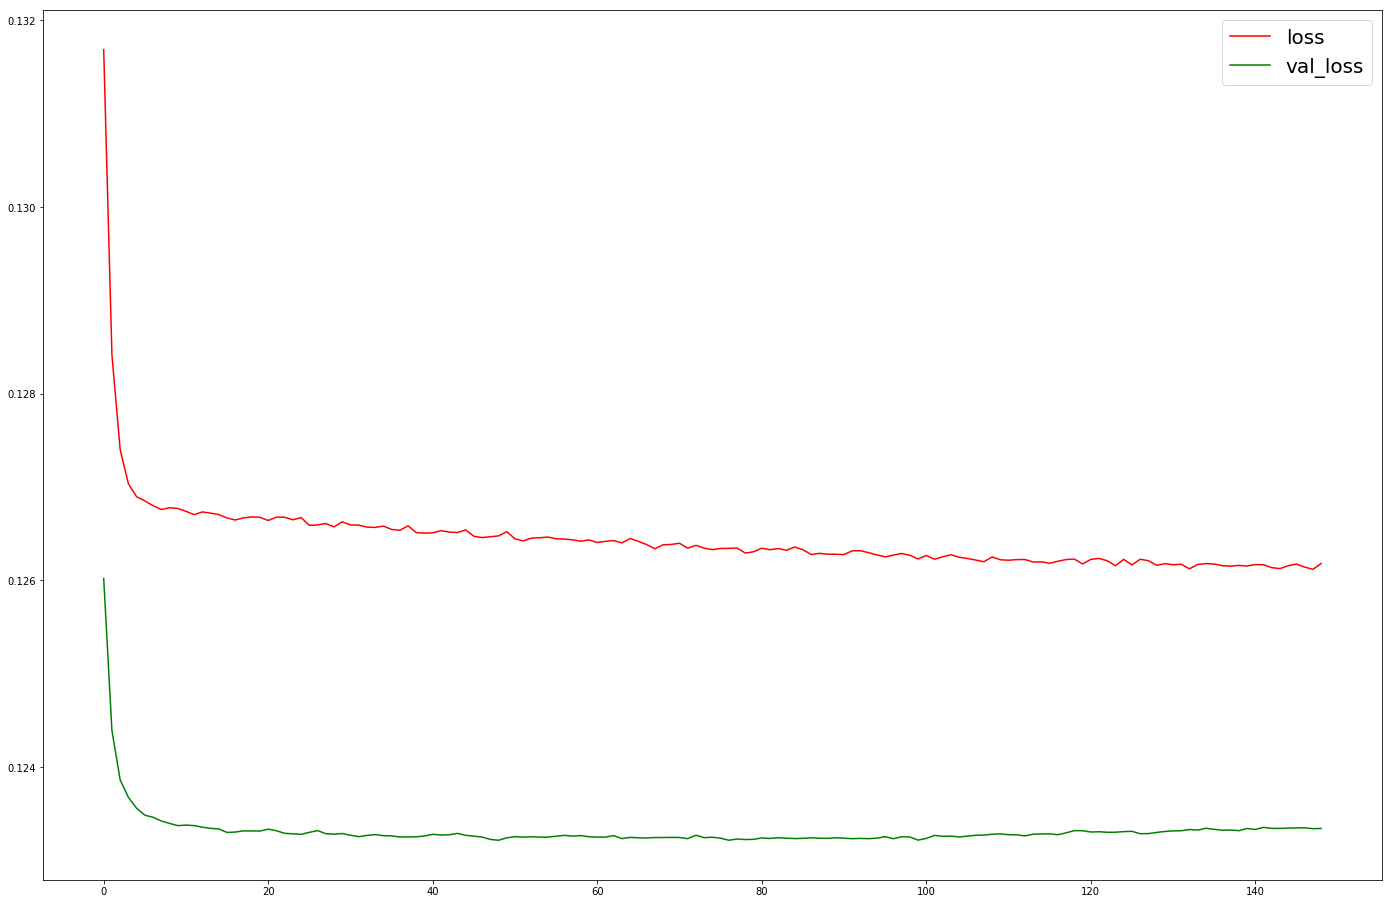

In [47]:
plt.plot(loss_df['loss'], color='red', label='loss')
plt.plot(val_loss_df['val_loss'], color='green', label='val_loss')
plt.legend(prop={'size': 20})
plt.show()